## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from scipy.stats import chi2_contingency
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

## Initializing Data

In [2]:
driver_dtypes = {'Local Case Number': "string", "Num Motorist Involved": "string"}
df = pd.read_csv("../Datasets/prepared_data.csv", dtype=driver_dtypes)

target3 = ["Num Motorist Involved"]
target3_feats = ["First Harmful Event", "Collision Type", "Driver At Fault", "NonTraffic", "Vehicle Movement",
                 "Number of Lanes", "Speed Limit", "Vehicle Second Impact Location", "Vehicle First Impact Location",
                 "Lane Number", "Vehicle Make", "Driver Substance Abuse", "Route Type", "Incident Hit/Run", "Light",
                 "Vehicle Body Type", "Traffic Analysis Zone", "Policy Name", "Hour Range"]

target3_df = df[target3+target3_feats]

## Checking Distribution

In [3]:
target3_df[target3].value_counts(normalize=True)

Num Motorist Involved
2                        0.674402
1                        0.180026
3                        0.113760
4+                       0.031812
dtype: float64

In [4]:
target3_df.shape

(171414, 20)

In [5]:
target3_df = target3_df.dropna()
target3_df[target3].value_counts(normalize=True)

Num Motorist Involved
2                        0.691733
1                        0.152689
3                        0.121800
4+                       0.033778
dtype: float64

In [6]:
target3_df.reset_index(inplace=True, drop=True)
target3_df.shape

(155813, 20)

In [7]:
def test_normality(distro):
    stat, p = stats.shapiro(distro)
    alpha = 0.05

    if p > alpha:
        print("p =",p)
        print("Normal Distribution (Fail to Reject Null Hypothesis)")
    else:
        print("Not Normal Distribution (Reject Null Hypothesis)")

In [8]:
test_normality(target3_df[target3].value_counts(normalize=True).tolist())

p = 0.07232625037431717
Normal Distribution (Fail to Reject Null Hypothesis)


## Test for Multicolinearity

In [9]:
corr = pd.DataFrame(index=target3_feats+target3, columns=target3_feats+target3)

In [10]:
def get_cramers_v(idx, col, n):
    contingency_table = pd.crosstab(idx, col)
    chi2, _, _, _ = chi2_contingency(contingency_table)
    feature_shape = contingency_table.shape[0]
    target_shape = contingency_table.shape[1]
    cramers_v = np.sqrt(chi2 / (n * min(feature_shape-1, target_shape-1)))
    return cramers_v

In [11]:
for idx in corr.index:
    for col in corr.columns:
        corr.at[idx, col] = get_cramers_v(target3_df[idx], target3_df[col], target3_df.shape[0])

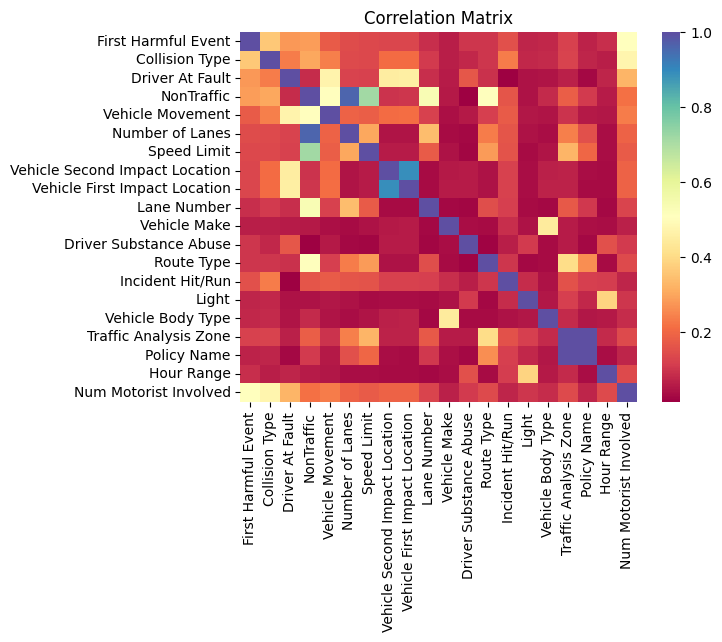

In [12]:
sns.heatmap(corr.astype(float), cmap=sns.color_palette("Spectral", as_cmap=True))
plt.title("Correlation Matrix")
plt.show()

To start I am going to remove a few features do to multicolinearity. 

**Traffic Analysis Zone** has a perfect correlation with Policy name. This make sense due to they were both derived from the same supplementary data set. While Traffic analysis zone does have a better correlation with the target variable than policy name, it also has 10 time the amount of features. Thus to reduce spatial complexity in the model, for the time being it makes the most sense to use policy name instead of traffic analysis zone.

**Number of Lanes** and Nontraffic also almost have a perfect correlation. NonTraffic being binary, and having a higher correlation with the target variable than Number of Lanes, makes it the feature that should be kept. Thus, Number of Lanes will be dropped from the dataset.

**Vehicle Second Impact Location** also has a high correlation with Vehicle First Impact Location. Both variables have the same correlation with the target so the second is what will be dropped as it comes after the first.

## Variable Encoding

In [13]:
target3_df.drop(columns=["Traffic Analysis Zone", "Number of Lanes", "Vehicle Second Impact Location"], inplace=True)

In [14]:
binary_feats = ["Incident Hit/Run", "NonTraffic", "Driver At Fault"]
ordinal_feats = ["Speed Limit", "Lane Number", "Vehicle First Impact Location", "Hour Range"]
nominal_feats = ["First Harmful Event", "Collision Type", "Vehicle Movement", "Vehicle Make", "Driver Substance Abuse",
                 "Route Type", "Light", "Vehicle Body Type", "Policy Name"]

In [15]:
model_df = pd.get_dummies(target3_df, columns=nominal_feats)

In [16]:
for col in binary_feats + ordinal_feats:
    model_df[col] = model_df[col].astype('category').cat.codes

## Classifiers
#### Parameter Selections

In [17]:
def gridSearch(clf, params, df, n_rows, score='f1_weighted', is_y_np=False):
    df = df[: n_rows]
    
    X_n = df.drop(columns=['Num Motorist Involved'])
    y_n = df['Num Motorist Involved']
    y_np = df['Num Motorist Involved'].astype('category').cat.codes
    
    grid_search = GridSearchCV(clf, params, cv=10, scoring=score)
    
    if is_y_np:
        grid_search.fit(X_n, y_np)
    else:
        grid_search.fit(X_n, y_n)
    
    return grid_search

In [18]:
%%time
rf_params = {
    'n_estimators': [50, 100, 200, 300, 500],
    'max_depth': [None, 5, 10, 15, 20, 25],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced']
}

gs_rf = gridSearch(RandomForestClassifier(), rf_params, model_df, int(model_df.shape[0]*.10)) 
print("Best Random Forest parameters found: ", gs_rf.best_params_)
print("Best Random Forest f1_weighted found: ", gs_rf.best_score_)

Best Random Forest parameters found:  {'class_weight': 'balanced', 'max_depth': 25, 'min_samples_split': 2, 'n_estimators': 100}
Best Random Forest f1_weighted found:  0.7404115044291106
CPU times: total: 44min 39s
Wall time: 46min 14s


In [19]:
%%time 
bernNB_params = {'fit_prior': [True, False],
                        'alpha': [0.1, 0.25, 0.5, 0.75, 1, 1.5, 2, 5, 10, 15, 20, 25, 50, 100]}
gs_bernNB = gridSearch(BernoulliNB(), bernNB_params, model_df.loc[:, ~model_df.columns.isin(ordinal_feats)], model_df.shape[0])
print("Best BernoulliNB parameters found: ", gs_bernNB.best_params_)
print("Best BernoulliNB f1_weighted found: ", gs_bernNB.best_score_)

Best BernoulliNB parameters found:  {'alpha': 100, 'fit_prior': True}
Best BernoulliNB f1_weighted found:  0.7658196085769923
CPU times: total: 5min 8s
Wall time: 5min 22s


In [20]:
%%time
compNB_params = {'norm': [True, False],
                 'alpha': [0.1, 0.25, 0.5, 0.75, 1, 1.5, 2, 5, 10, 15, 20, 25, 50, 100]}
gs_compNB = gridSearch(ComplementNB(), compNB_params, model_df, model_df.shape[0])
print("Best ComplementNB parameters found: ", gs_compNB.best_params_)
print("Best ComplementNB f1_weighted found: ", gs_compNB.best_score_)

Best ComplementNB parameters found:  {'alpha': 20, 'norm': True}
Best ComplementNB f1_weighted found:  0.7382601244250238
CPU times: total: 4min 31s
Wall time: 4min 44s


In [23]:
%%time
xgb_params = {'booster': ['gbtree'],
              'eta': [0.01, 0.05, 0.1],
              'max_depth': [3, 6, 9],
              'min_child_weight': [0.25, 0.5, 1, 5],
              'lambda': [0.1, 1.0, 10.0],
              'alpha': [0.0, 0.1, 0.5],
              'objective': ['multi:softmax'],
              'num_class': [4],
              'tree_method':['hist']}

gs_xgb = gridSearch(xgb.XGBClassifier(), xgb_params, model_df, int(model_df.shape[0]*.10), is_y_np=True)
print("Best XGBoost parameters found: ", gs_xgb.best_params_)
print("Best XGBoost f1_weighted found: ", gs_xgb.best_score_)

Best XGBoost parameters found:  {'alpha': 0.0, 'booster': 'gbtree', 'eta': 0.1, 'lambda': 0.1, 'max_depth': 9, 'min_child_weight': 5, 'num_class': 4, 'objective': 'multi:softmax', 'tree_method': 'hist'}
Best XGBoost f1_weighted found:  0.7304844031177266
CPU times: total: 12h 14min 48s
Wall time: 1h 21min 34s


#### Model Evaluations with Selected Parameters

In [24]:
classifiers = ["Random Forest", "BernoulliNB", "ComplementNB", "XGBoost"]
accs = []
f1s = []

In [25]:
def plot_cm(df, title):
    plt.figure(figsize=(10, 6))
    sns.heatmap(df, cmap = 'viridis', annot=True, fmt="d", square=True, linewidths=.5)
    plt.xlabel("Predicted Values", fontsize=10)
    plt.ylabel("Actual Values", fontsize=10)
    plt.xticks(wrap=True, fontsize=7, rotation=0)
    plt.yticks(wrap=True, fontsize=7)
    plt.title(title)
    plt.show()

In [26]:
def kfold_eval(clf, X, y, nparray=False):
    acc = []
    f1_weighted = []
    cm = []
    kf = StratifiedKFold(n_splits=10, shuffle=False)
    if not nparray:
        for train, test in kf.split(X, y):
            clf.fit(X.iloc[train], y[train])
            y_pred = clf.predict(X.iloc[test])
            class_names = sorted(set(y[test]) | set(y_pred))
            acc += [accuracy_score(y[test], y_pred)]
            f1_weighted += [f1_score(y[test], y_pred, average='weighted')]
            cm += [pd.DataFrame(confusion_matrix(y[test], y_pred, labels=class_names), index=class_names, columns=class_names)]
    else:
        for train, test in kf.split(X, y):
            clf.fit(X[train], y[train])
            y_pred = clf.predict(X[test])
            class_names = sorted(set(y[test]) | set(y_pred))
            acc += [accuracy_score(y[test], y_pred)]
            f1_weighted += [f1_score(y[test], y_pred, average='weighted')]
            cm += [pd.DataFrame(confusion_matrix(y[test], y_pred, labels=class_names), index=class_names, columns=class_names)]
    return acc, f1_weighted, cm

In [27]:
X = model_df.drop(columns=['Num Motorist Involved'])
y = model_df['Num Motorist Involved']

X_np = model_df.drop(columns=['Num Motorist Involved']).values
y_np = model_df['Num Motorist Involved'].values
y_np = LabelEncoder().fit_transform(y_np)

In [28]:
%%time
rf = RandomForestClassifier(**gs_rf.best_params_)

acc, f1_weighted, cm = kfold_eval(rf, X, y)
accs.append(np.mean(acc)); f1s.append(np.mean(f1_weighted))
print(f'Random Forest CV accuracy={np.mean(acc):.3f} {np.std(acc):.3f}')
print(f'Random Forest CV f1_weighted={np.mean(f1_weighted):.3f} {np.std(f1_weighted):.3f}')

Random Forest CV accuracy=0.729 0.003
Random Forest CV f1_weighted=0.755 0.003
CPU times: total: 3min 55s
Wall time: 4min 11s


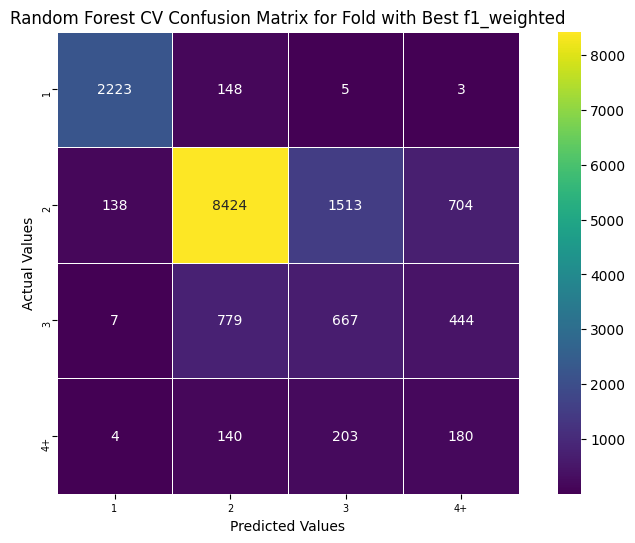

In [29]:
plot_cm(cm[f1_weighted.index(max(f1_weighted))], 'Random Forest CV Confusion Matrix for Fold with Best f1_weighted')

In [30]:
%%time
bernNB = BernoulliNB(**gs_bernNB.best_params_)

acc, f1_weighted, cm = kfold_eval(bernNB, X, y)
accs.append(np.mean(acc)); f1s.append(np.mean(f1_weighted))
print(f'BernoulliNB CV accuracy={np.mean(acc):.3f} {np.std(acc):.3f}')
print(f'BernoulliNB CV f1_weighted={np.mean(f1_weighted):.3f} {np.std(f1_weighted):.3f}')

BernoulliNB CV accuracy=0.777 0.003
BernoulliNB CV f1_weighted=0.765 0.004
CPU times: total: 12.1 s
Wall time: 12.9 s


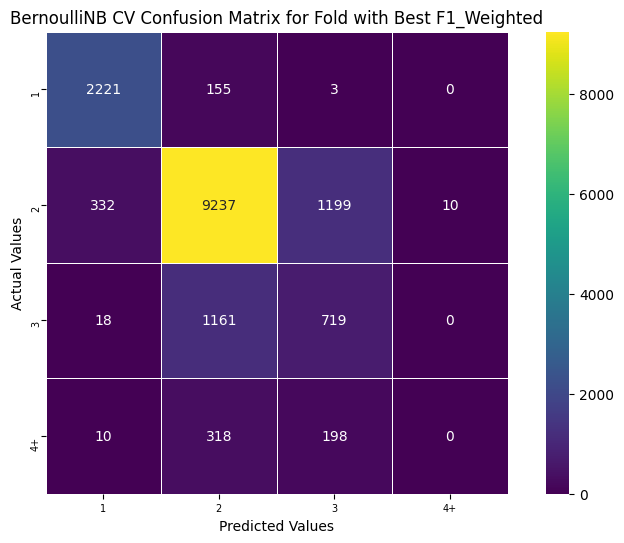

In [31]:
plot_cm(cm[f1_weighted.index(max(f1_weighted))], 'BernoulliNB CV Confusion Matrix for Fold with Best F1_Weighted')

In [32]:
%%time
compNB = ComplementNB(**gs_compNB.best_params_)

acc, f1_weighted, cm = kfold_eval(compNB, X, y)
accs.append(np.mean(acc)); f1s.append(np.mean(f1_weighted))
print(f'ComplementNB CV accuracy={np.mean(acc):.3f} {np.std(acc):.3f}')
print(f'ComplementNB CV f1_weighted={np.mean(f1_weighted):.3f} {np.std(f1_weighted):.3f}')

ComplementNB CV accuracy=0.764 0.005
ComplementNB CV f1_weighted=0.738 0.004
CPU times: total: 11 s
Wall time: 11.8 s


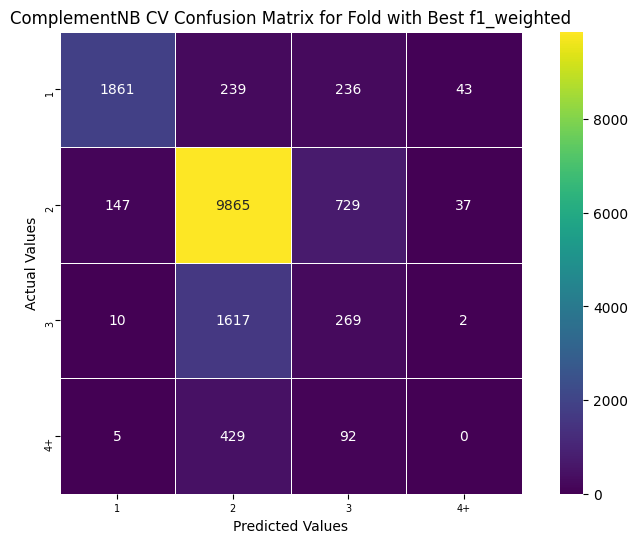

In [33]:
plot_cm(cm[f1_weighted.index(max(f1_weighted))], 'ComplementNB CV Confusion Matrix for Fold with Best f1_weighted')

In [34]:
%%time
xgb_clf = xgb.XGBClassifier(**gs_xgb.best_params_)

acc, f1_weighted, cm = kfold_eval(xgb_clf, X, y_np)
accs.append(np.mean(acc)); f1s.append(np.mean(f1_weighted))
print(f'XGBoost CV accuracy={np.mean(acc):.3f} {np.std(acc):.3f}')
print(f'XGBoost CV f1_weighted={np.mean(f1_weighted):.3f} {np.std(f1_weighted):.3f}')

XGBoost CV accuracy=0.828 0.002
XGBoost CV f1_weighted=0.770 0.002
CPU times: total: 13min 58s
Wall time: 1min 24s


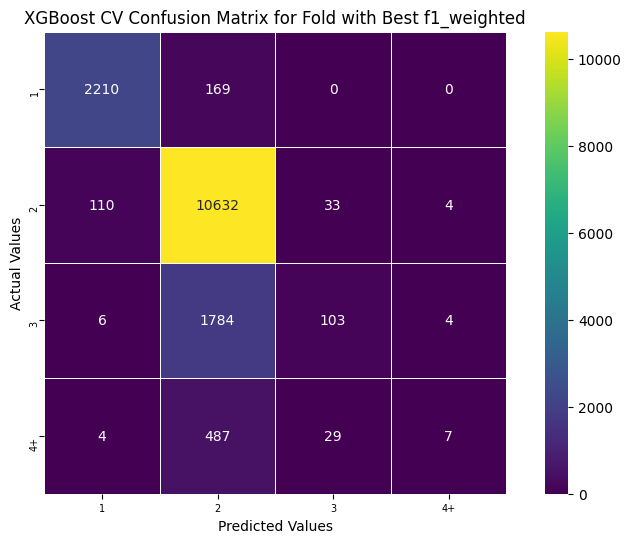

In [35]:
best_cm = cm[f1_weighted.index(max(f1_weighted))]
best_cm.index = target3_df['Num Motorist Involved'].unique().tolist()
best_cm.columns = target3_df['Num Motorist Involved'].unique().tolist()
plot_cm(best_cm, 'XGBoost CV Confusion Matrix for Fold with Best f1_weighted')

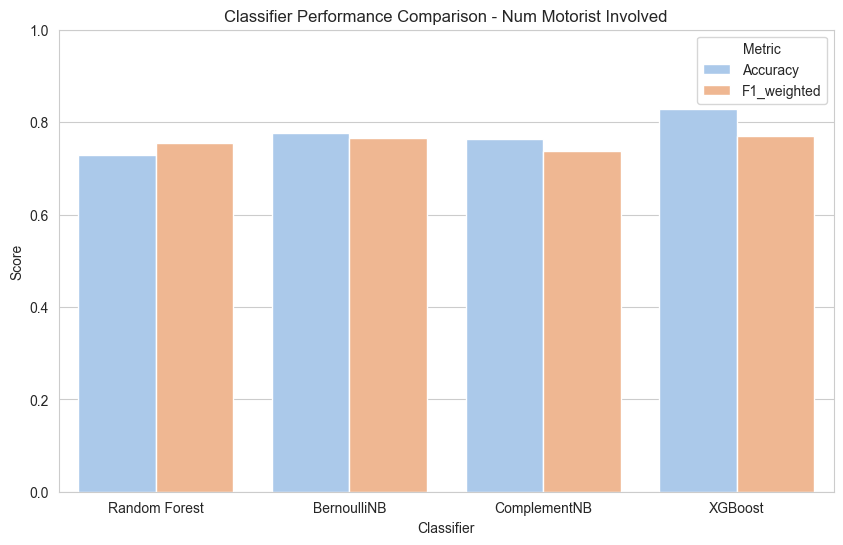

In [36]:
sns.set_style("whitegrid")
sns.set_palette("pastel")

data = {
    'Classifier': classifiers,
    'Accuracy': accs,
    'F1_weighted': f1s
}

results = pd.DataFrame(data)
results = pd.melt(results, id_vars='Classifier', var_name='Metric', value_name='Value')

plt.figure(figsize=(10, 6))
sns.barplot(data=results, x='Classifier', y='Value', hue='Metric')
plt.title('Classifier Performance Comparison - Num Motorist Involved')
plt.ylabel('Score')
plt.xlabel('Classifier')
plt.ylim(0, 1)
plt.legend(title='Metric')
plt.show()